<a href="https://colab.research.google.com/github/Hazuna227/221230039-Pengantar-ML/blob/main/project_week/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical

print("Library siap digunakan!")

Library siap digunakan!


In [ ]:
# Lokasi file (sesuaikan jika nama folder berbeda)
TRAIN_PATH = 'dataset/fashion-mnist_train.csv'
TEST_PATH = 'dataset/fashion-mnist_test.csv'

print("Sedang membaca file CSV... (Mungkin butuh waktu 1-2 menit)")

# 1. Baca CSV menggunakan Pandas
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"Data Train Loaded: {train_df.shape}")
print(f"Data Test Loaded: {test_df.shape}")

# 2. Pisahkan Label dan Pixel
# Kolom pertama (index 0) adalah label, sisanya adalah pixel
X_train_raw = train_df.iloc[:, 1:].values.astype('float32') # Pixel
y_train = train_df.iloc[:, 0].values.astype('int')          # Label

X_test_raw = test_df.iloc[:, 1:].values.astype('float32')   # Pixel
y_test = test_df.iloc[:, 0].values.astype('int')            # Label

# Hapus dataframe pandas untuk menghemat RAM laptop
del train_df
del test_df

# 3. Normalisasi (0-255 -> 0-1)
X_train_norm = X_train_raw / 255.0
X_test_norm = X_test_raw / 255.0

# 4. PREPROCESSING BENTUK DATA
# A. Untuk SVM & MLP (Tetap datar/1D array)
# Tidak perlu diubah karena CSV sudah format datar (row, 784)
X_train_flat = X_train_norm
X_test_flat = X_test_norm

# B. Untuk CNN (Harus diubah ke 3D: 28x28x1)
X_train_cnn = X_train_norm.reshape(-1, 28, 28, 1)
X_test_cnn = X_test_norm.reshape(-1, 28, 28, 1)

# C. One-Hot Encoding Label untuk Neural Network (MLP & CNN)
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Buat data validasi kecil dari training set (untuk memantau belajar model)
from sklearn.model_selection import train_test_split
X_train_cnn, X_val_cnn, y_train_cat, y_val_cat = train_test_split(X_train_cnn, y_train_cat, test_size=0.1, random_state=42)
# Sesuaikan juga versi flat-nya untuk MLP nanti jika perlu, atau pakai split manual
# Kita pakai split otomatis di fungsi fit saja nanti untuk MLP

print("Preprocessing Selesai!")
print(f"Shape untuk SVM/MLP: {X_train_flat.shape}")
print(f"Shape untuk CNN: {X_train_cnn.shape}")

Sedang membaca file CSV... (Mungkin butuh waktu 1-2 menit)
Data Train Loaded: (60000, 785)
Data Test Loaded: (10000, 785)
Preprocessing Selesai!
Shape untuk SVM/MLP: (60000, 784)
Shape untuk CNN: (54000, 28, 28, 1)


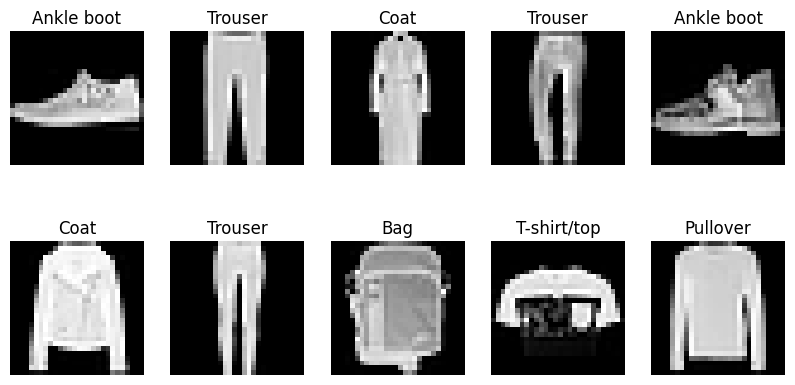

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    # Kita ambil dari data CNN karena sudah berbentuk kotak (28x28)
    img = X_train_cnn[i].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    label_index = np.argmax(y_train_cat[i])
    plt.title(class_names[label_index])
    plt.axis('off')
plt.show()

In [ ]:
print("--- Training SVM ---")
start = time.time()

# Kita latih dengan 10.000 data pertama saja agar cepat
# (Dataset asli ada 60.000, SVM akan sangat lama jika dipakai semua di local)
limit = 10000
svm_model = SVC(kernel='rbf', C=10)
svm_model.fit(X_train_flat[:limit], y_train[:limit])

# Prediksi
y_pred_svm = svm_model.predict(X_test_flat)
acc_svm = accuracy_score(y_test, y_pred_svm)

print(f"Waktu Training: {time.time() - start:.2f} detik")
print(f"Akurasi SVM: {acc_svm * 100:.2f}%")

--- Training SVM ---
Waktu Training: 21.61 detik
Akurasi SVM: 87.49%


In [ ]:
print("--- Training MLP ---")

model_mlp = Sequential([
    Dense(512, activation='relu', input_shape=(784,)), # Input 784 pixel
    Dense(256, activation='relu'),                     # Hidden 1
    Dense(128, activation='relu'),                     # Hidden 2
    Dense(10, activation='softmax')                    # Output 10 kelas
])

model_mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Kita gunakan data flat (X_train_flat) tapi perlu displit validasi manual atau pakai parameter split
history_mlp = model_mlp.fit(X_train_flat, to_categorical(y_train, 10),
                            epochs=15,
                            batch_size=128,
                            validation_split=0.1, # Ambil 10% data train buat validasi
                            verbose=1)

loss_mlp, acc_mlp = model_mlp.evaluate(X_test_flat, y_test_cat)
print(f"Akurasi MLP: {acc_mlp * 100:.2f}%")

--- Training MLP ---
Epoch 1/15


c:\Users\raang\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8162 - loss: 0.5120 - val_accuracy: 0.8495 - val_loss: 0.4035
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8646 - loss: 0.3668 - val_accuracy: 0.8653 - val_loss: 0.3843
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8796 - loss: 0.3278 - val_accuracy: 0.8843 - val_loss: 0.3254
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8876 - loss: 0.3017 - val_accuracy: 0.8815 - val_loss: 0.3305
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8952 - loss: 0.2850 - val_accuracy: 0.8793 - val_loss: 0.3363
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8980 - loss: 0.2723 - val_accuracy: 0.8890 - val_loss: 0.3145
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9031 - loss: 0.2583 - val_accuracy: 0.8887 - val_loss: 0.3096
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9057 - loss: 0.2471 - val_accuracy: 0.8890 - val_

In [ ]:
print("--- Training CNN (Mohon Tunggu...) ---")

# Definisikan Model CNN
model_cnn = Sequential([
    # Conv Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    # Conv Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten & Dense
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
# Pastikan X_train_cnn dan y_train_cat sudah ada dari Cell 2
history_cnn = model_cnn.fit(X_train_cnn, y_train_cat,
                            epochs=10, # Saya kurangi jadi 10 biar agak cepat
                            batch_size=128,
                            validation_split=0.1,
                            verbose=1)

# Evaluasi untuk mendapatkan variabel acc_cnn
print("Menghitung akurasi CNN...")
loss_cnn, acc_cnn = model_cnn.evaluate(X_test_cnn, y_test_cat)
print(f"Akurasi CNN Berhasil Disimpan: {acc_cnn * 100:.2f}%")

--- Training CNN (Mohon Tunggu...) ---
Epoch 1/10


c:\Users\raang\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7610 - loss: 0.6582 - val_accuracy: 0.8439 - val_loss: 0.4222
Epoch 2/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8472 - loss: 0.4270 - val_accuracy: 0.8569 - val_loss: 0.3744
Epoch 3/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8652 - loss: 0.3743 - val_accuracy: 0.8763 - val_loss: 0.3420
Epoch 4/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8761 - loss: 0.3429 - val_accuracy: 0.8880 - val_loss: 0.3146
Epoch 5/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8844 - loss: 0.3157 - val_accuracy: 0.8967 - val_loss: 0.2938
Epoch 6/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8907 - loss: 0.2971 - val_accuracy: 0.9004 - val_loss: 0.2808
Epoch 7/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8982 - loss: 0.2802 - val_accuracy: 0.9020 - val_loss: 0.2720
Epoch 8/10
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9027 - loss: 0.2659 - val_accuracy: 0.9076 - va

Skor saat ini -> SVM: 0.87, MLP: 0.90, CNN: 0.91


C:\Users\raang\AppData\Local\Temp\ipykernel_14688\1419436823.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=scores, palette='viridis')


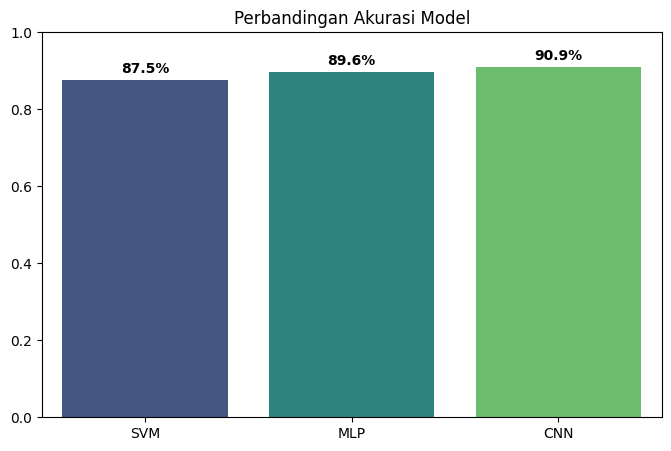

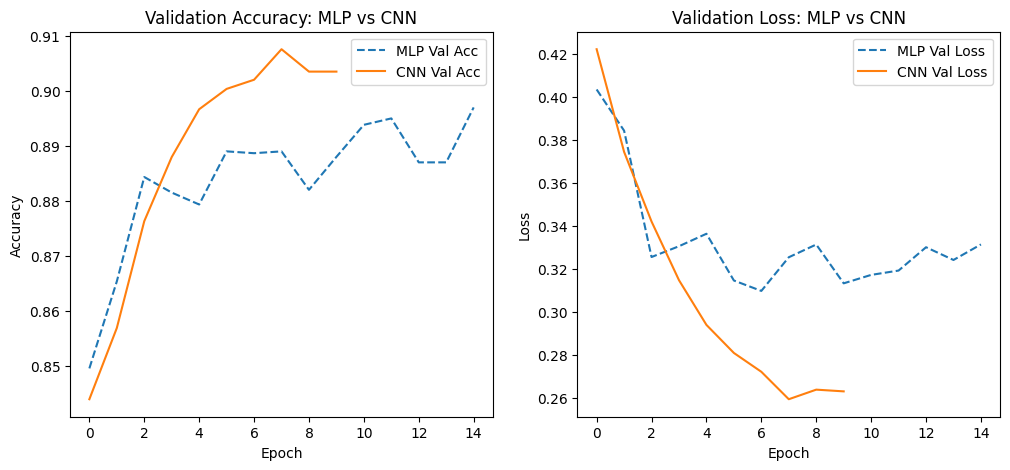

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- BAGIAN PENGECEKAN VARIABEL ---
# Kita cek apakah model sebelumnya sudah dijalankan.
# Jika belum, kita kasih nilai 0 agar tidak error (NameError).
if 'acc_svm' not in locals():
    print("WARNING: Model SVM belum dijalankan. Nilai diset ke 0.")
    acc_svm = 0
if 'acc_mlp' not in locals():
    print("WARNING: Model MLP belum dijalankan. Nilai diset ke 0.")
    acc_mlp = 0
if 'acc_cnn' not in locals():
    print("WARNING: Model CNN belum dijalankan. Nilai diset ke 0.")
    acc_cnn = 0

print(f"Skor saat ini -> SVM: {acc_svm:.2f}, MLP: {acc_mlp:.2f}, CNN: {acc_cnn:.2f}")
# ----------------------------------

# 1. Grafik Perbandingan Akurasi
models = ['SVM', 'MLP', 'CNN']
scores = [acc_svm, acc_mlp, acc_cnn]

plt.figure(figsize=(8, 5))
# Menggunakan palet warna yang jelas
sns.barplot(x=models, y=scores, palette='viridis')
plt.title('Perbandingan Akurasi Model')
plt.ylim(0, 1.0)

# Menambahkan label angka di atas batang
for i, v in enumerate(scores):
    plt.text(i, v + 0.02, f"{v*100:.1f}%", ha='center', fontweight='bold')
plt.show()

# 2. Learning Curve (Hanya jalan jika MLP dan CNN sudah dilatih)
if 'history_mlp' in locals() and 'history_cnn' in locals():
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_mlp.history['val_accuracy'], label='MLP Val Acc', linestyle='--')
    plt.plot(history_cnn.history['val_accuracy'], label='CNN Val Acc')
    plt.title('Validation Accuracy: MLP vs CNN')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_mlp.history['val_loss'], label='MLP Val Loss', linestyle='--')
    plt.plot(history_cnn.history['val_loss'], label='CNN Val Loss')
    plt.title('Validation Loss: MLP vs CNN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print("Learning curve tidak bisa ditampilkan karena history training tidak ditemukan.")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


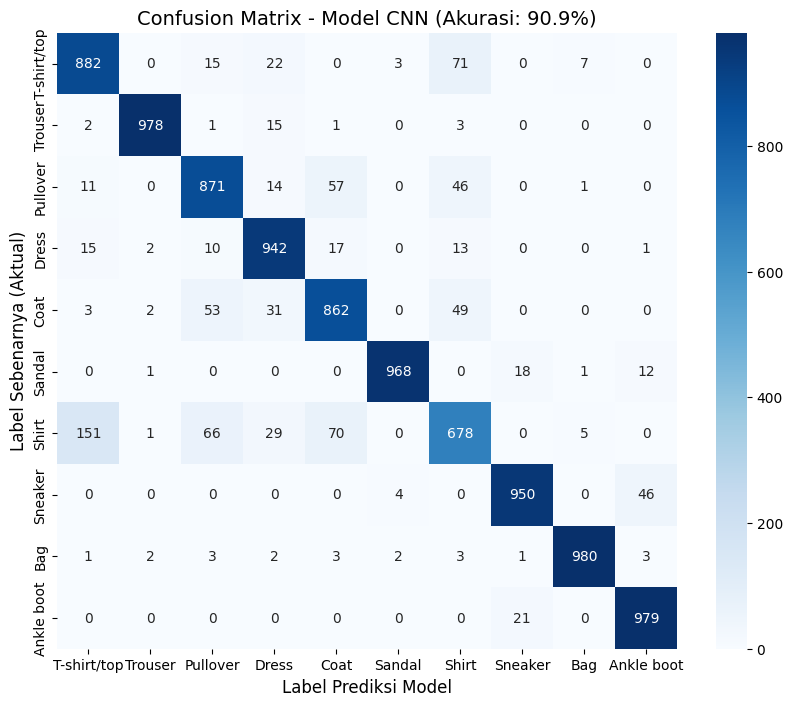


Detail Performa per Kelas:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.88      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.85      0.87      0.86      1000
       Dress       0.89      0.94      0.92      1000
        Coat       0.85      0.86      0.86      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.79      0.68      0.73      1000
     Sneaker       0.96      0.95      0.95      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.94      0.98      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
# --- Cell Tambahan: Confusion Matrix untuk Model Terbaik (CNN) ---

import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Tentukan Label Kelas Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 2. Lakukan Prediksi menggunakan Model CNN (Pemenang)
# Kita gunakan X_test_cnn yang berbentuk 3D
y_pred_probs = model_cnn.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred_probs, axis=1) # Ubah probabilitas jadi angka kelas (0-9)

# 3. Buat Matriks Kebingungan (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred_classes)

# 4. Visualisasi dengan Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title('Confusion Matrix - Model CNN (Akurasi: 90.9%)', fontsize=14)
plt.ylabel('Label Sebenarnya (Aktual)', fontsize=12)
plt.xlabel('Label Prediksi Model', fontsize=12)
plt.show()

# 5. Tampilkan detail angka per kelas
print("\nDetail Performa per Kelas:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))